# Use AutoML for forecasting wind generation

Utilising MERRA2, ERA5 and ECWMF forecasts

In [44]:
import requests
from pathlib import Path
from tqdm import tqdm

import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from autogluon.tabular import TabularPredictor

import os

import pickle

import cdsapi

import xarray as xr
import matplotlib.pyplot as plt

from autogluon.tabular import TabularPredictor

In [45]:
autoML_duration_mins = 4

In [46]:
lat = 52.4
lon = -0.94

In [47]:
BYTES_MB = 1024 * 1024

In [48]:
def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [49]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [50]:
data_path = "data/scada_energy_theoretical.csv"

if os.path.exists(data_path):
    # Load your existing predictor from its saved directory
    scada = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
else:
    
    record_id = 8252025
    url_zenodo = r"https://zenodo.org/api/records/"
    r = requests.get(f"{url_zenodo}{record_id}")
    r_json = r.json()

    files = r_json["files"]

    for file in files:
        
        if "SCADA" in file["links"]["self"]:
    
            url = f"https://zenodo.org/records/8252025/files/{file["key"]}?download=1"
            outfile = Path(f"data/{file["key"]}")

            if not outfile.is_file():
                print(url)
                try:
                    download_file(url,outfile)
                except:
                    print("Failed to download file. Removing it.")
                    outfile.unlink()
                    continue

            with zipfile.ZipFile(outfile,"r") as zip_ref:
                zip_ref.extractall(path="data")

    scada_files = list(Path().rglob("data/Turbine_Data*.csv"))

    use_columns = [
                "# Date and time",
                #"Power (kW)",
                "Energy Theoretical (kWh)"
            ]

    csv_params = {
            "index_col": "# Date and time",
            "parse_dates": True,
            "skiprows": 9,
            "usecols": use_columns,
        }

    print(str(scada_files[0])[-42:-32])

    scada_lst = []

    for file in scada_files:
        turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

        scada_wt = pd.read_csv(file, **csv_params)

        scada_wt["Turbine"] = turbine_name
        scada_wt.index.names = ["Timestamp"]
        scada_lst.append(scada_wt.copy())

    scada = pd.concat(scada_lst)

    scada.to_csv(data_path)

In [51]:
scada

,Energy Theoretical (kWh),Turbine
Timestamp,,
2016-01-03 00:00:00,NaN,Kelmarsh_1
2016-01-03 00:10:00,NaN,Kelmarsh_1
2016-01-03 00:20:00,NaN,Kelmarsh_1
2016-01-03 00:30:00,NaN,Kelmarsh_1
2016-01-03 00:40:00,NaN,Kelmarsh_1
...,...,...
2022-12-31 23:10:00,220.959389,Kelmarsh_6
2022-12-31 23:20:00,248.510113,Kelmarsh_6
2022-12-31 23:30:00,273.517162,Kelmarsh_6


In [52]:
for year in range(2000,2026):
    outfile = Path(f"data/era5/era5_{year}.grib")

    if not outfile.is_file():
        print(f"Downloading to: {outfile}")

        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": [
                "2m_temperature",
                "100m_u_component_of_wind",
                "100m_v_component_of_wind"
            ],
            "year": [str(year)],
            "month": ["01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": [
                "00:00", "01:00", "02:00",
                "03:00", "04:00", "05:00",
                "06:00", "07:00", "08:00",
                "09:00", "10:00", "11:00",
                "12:00", "13:00", "14:00",
                "15:00", "16:00", "17:00",
                "18:00", "19:00", "20:00",
                "21:00", "22:00", "23:00"
            ],
            "data_format": "grib",
            "download_format": "unarchived",
            "area": [lat+1, lon-1, lat-1, lon+1]
        }

        client = cdsapi.Client()
        client.retrieve(dataset, request, outfile)

In [ ]:
outfile = Path(f"data/era5.csv")

if not outfile.is_file():
    print(f"Downloading to: {outfile}")
    
    # Open the dataset
    ds = xr.open_mfdataset(f"data/era5/era5_20*.grib", engine="cfgrib")

    # Reset unwanted coordinates
    ds = ds.reset_coords(['number', 'step', 'surface', 'valid_time'], drop=True)

    # Select the nearest grid point
    selected_data = ds.sel(latitude=lat, longitude=lon)

    # Convert the selected data to a pandas DataFrame
    df_era5 = selected_data.to_dataframe()

    # Save the DataFrame to a CSV file
    df_era5.to_csv(outfile)

else:
    df_era5 = pd.read_csv(outfile, index_col=0, parse_dates=True)


df_era5 = df_era5[["t2m","u100","v100"]]


for shift in range(-24,25,1):
    df_era5[f"u100_shift_{shift}"] = df_era5["u100"].shift(shift)
    df_era5[f"v100_shift_{shift}"] = df_era5["v100"].shift(shift)


In [54]:
# outfile = Path(f"data/era5_9nodes.csv")

# if not outfile.is_file():
#     print(f"Downloading to: {outfile}")
    
#     # Open the dataset
#     ds = xr.open_mfdataset(f"data/era5/era5_20*.grib", engine="cfgrib")

#     # Reset unwanted coordinates
#     ds = ds.reset_coords(['number', 'step', 'surface', 'valid_time'], drop=True)

#     # Find the index of the nearest latitude and longitude
#     lat_idx = int(np.abs(ds.latitude - lat).argmin())
#     lon_idx = int(np.abs(ds.longitude - lon).argmin())

#     # Determine the slice boundaries for a 3x3 block, handling edges if needed
#     lat_start = max(0, lat_idx - 1)
#     lat_end = lat_idx + 2  # +2 because Python slicing is exclusive at the end
#     lon_start = max(0, lon_idx - 1)
#     lon_end = lon_idx + 2

#     # Select the 9 nearest grid points using isel (index selection)
#     selected_data = ds.isel(latitude=slice(lat_start, lat_end), longitude=slice(lon_start, lon_end))

#     # Convert the selected data to a pandas DataFrame
#     df_era5 = selected_data.to_dataframe()

#     # Save the DataFrame to a CSV file
#     df_era5.to_csv(outfile)

# else:
#     df_era5 = pd.read_csv(outfile, index_col=0, parse_dates=True)


In [ ]:
# df_era5_backup = df_era5.copy()

In [ ]:
# df_era5 = df_era5_backup.copy()

In [ ]:
# # At this point, df_era5 should have columns like 'time', 'latitude', 'longitude', and your data variable(s)
# # Determine which column holds the variable you want (here we pick the first one that's not a coordinate)
# coord_columns = ['time', 'latitude', 'longitude']
# value_columns = [col for col in df_era5.columns if col not in coord_columns]
# variables = ["t2m","u100","v100"]  # adjust if necessary

# # Convert the selected data to a DataFrame.
# # This DataFrame will have a MultiIndex with time, latitude, and longitude.
# df_era5 = df_era5.reset_index()

# # Create a new column that concatenates the latitude and longitude into a single string label
# df_era5['latlon'] = df_era5.apply(lambda row: f"{row['latitude']}_{row['longitude']}", axis=1)

# # If you want to include multiple variables (e.g., t2m, u100, v100) in a single DataFrame
# # we first melt the DataFrame so that we can later pivot to a flat structure.
# value_vars = ['t2m', 'u100', 'v100']  # Adjust or add variables as needed

# df_melt = df_era5.melt(id_vars=['time', 'latlon'], value_vars=value_vars, 
#                   var_name='variable', value_name='value')

# # Create a new column combining the variable name and the latlon
# df_melt['combined'] = df_melt['variable'] + "_" + df_melt['latlon']

# # Pivot the melted DataFrame so that:
# # - 'time' becomes the index
# # - 'combined' becomes the columns
# # - 'value' are the cell values
# df_final = df_melt.pivot(index='time', columns='combined', values='value')

# # (Optional) sort the columns
# df_final = df_final.sort_index(axis=1)

# # Save the final DataFrame to a CSV file
# df_final.to_csv('data/era5_combined.csv')

# for shift in range(-24,25,1):
#     df_final[f"u100_shift_{shift}"] = df_final["u100_52.4_-0.94"].shift(shift)
#     df_final[f"v100_shift_{shift}"] = df_final["v100_52.4_-0.94"].shift(shift)


In [61]:
scada_hourly = scada.pivot(columns="Turbine", values="Energy Theoretical (kWh)")

scada_hourly = scada_hourly.dropna()

scada_hourly = scada_hourly.resample("h").sum()

In [62]:
scada_site_hourly = pd.DataFrame(scada_hourly.sum(axis=1))
scada_site_hourly.columns=["Energy Theoretical (kWh)"]

<Axes: xlabel='Timestamp'>

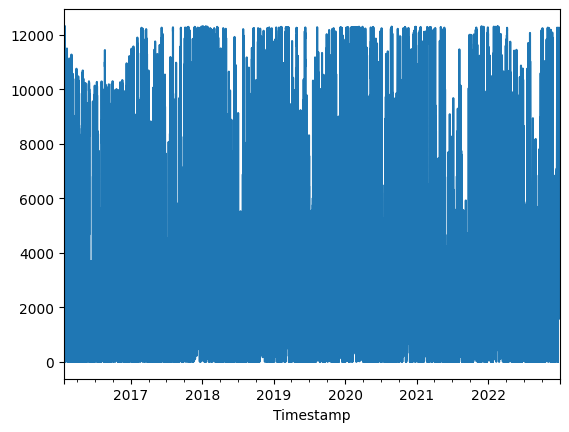

In [63]:
scada_site_hourly["Energy Theoretical (kWh)"].plot()

In [64]:
scada_site_hourly = scada_site_hourly.loc["2018":]

In [ ]:
#scada_site_hourly = scada_site_hourly.merge(df_era5, left_index=True, right_index=True)
scada_site_hourly = scada_site_hourly.merge(df_era5, left_index=True, right_index=True)

In [66]:
scada_site_hourly

,Energy Theoretical (kWh),t2m_52.15_-0.69,t2m_52.15_-0.94,t2m_52.15_-1.19,t2m_52.4_-0.69,t2m_52.4_-0.94,t2m_52.4_-1.19,t2m_52.65_-0.69,t2m_52.65_-0.94,t2m_52.65_-1.19,...,u100_shift_20,v100_shift_20,u100_shift_21,v100_shift_21,u100_shift_22,v100_shift_22,u100_shift_23,v100_shift_23,u100_shift_24,v100_shift_24
2018-01-01 00:00:00,11345.543629,279.26886,278.92352,278.65740,279.01240,278.65234,278.41248,278.85602,278.56274,278.39075,...,10.669250,11.060684,10.395433,10.741347,8.055436,11.574661,3.932293,10.857470,-0.253211,9.511244
2018-01-01 01:00:00,10473.868241,278.30707,278.05200,277.89697,278.02136,277.73407,277.57758,277.90740,277.63672,277.52942,...,10.533555,10.676737,10.669250,11.060684,10.395433,10.741347,8.055436,11.574661,3.932293,10.857470
2018-01-01 02:00:00,11540.792105,277.98248,277.82587,277.77368,277.68713,277.49274,277.42554,277.60840,277.42322,277.40417,...,10.532361,10.118890,10.533555,10.676737,10.669250,11.060684,10.395433,10.741347,8.055436,11.574661
2018-01-01 03:00:00,11925.247621,277.86950,277.77112,277.78840,277.54297,277.42584,277.45642,277.41046,277.31348,277.38147,...,10.962587,8.718340,10.532361,10.118890,10.533555,10.676737,10.669250,11.060684,10.395433,10.741347
2018-01-01 04:00:00,9878.207874,278.17400,278.12958,278.20830,277.90546,277.82208,277.86035,277.68090,277.60156,277.67352,...,10.568226,7.472130,10.962587,8.718340,10.532361,10.118890,10.533555,10.676737,10.669250,11.060684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,8205.421020,285.22382,285.01953,284.77838,284.82043,284.62140,284.44287,284.35822,284.18677,284.03113,...,7.221338,8.535692,7.924212,8.145590,8.902271,7.766553,9.033313,7.700175,9.769144,7.486769
2022-12-31 20:00:00,7940.013311,285.13873,284.73790,284.45007,284.79822,284.39935,284.12622,284.64540,284.26605,283.99060,...,6.496593,8.187078,7.221338,8.535692,7.924212,8.145590,8.902271,7.766553,9.033313,7.700175
2022-12-31 21:00:00,9899.108861,284.80237,284.37354,284.02917,284.38610,283.99463,283.72840,284.20837,283.88916,283.63380,...,5.621401,9.003526,6.496593,8.187078,7.221338,8.535692,7.924212,8.145590,8.902271,7.766553
2022-12-31 22:00:00,9722.141787,284.15295,283.80463,283.53522,283.86957,283.49335,283.18756,283.66614,283.31190,283.05860,...,5.365583,9.780439,5.621401,9.003526,6.496593,8.187078,7.221338,8.535692,7.924212,8.145590


In [68]:
target_feature = "Energy Theoretical (kWh)"

model_path = f"AutogluonModels/energy_forecasts/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{autoML_duration_mins:02d}mins"

if os.path.exists(model_path):
    # Load your existing predictor from its saved directory
    predictor = TabularPredictor.load(model_path)

else:
    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae',
        path=model_path,
    )
    predictor.fit(
        train_data=scada_site_hourly, 
        time_limit=60*autoML_duration_mins, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto',
    )

In [ ]:
prediction_path = f"predictions/energy_forecasts/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction = pickle.load(file)

else:
    target_prediction = predictor.predict(df_era5)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction, file)



In [70]:
target_prediction.name = "target_prediction"

In [71]:
target_prediction = pd.DataFrame(target_prediction)

In [72]:
target_prediction

,target_prediction
2018-01-01 00:00:00,11678.817383
2018-01-01 01:00:00,10870.076172
2018-01-01 02:00:00,11729.953125
2018-01-01 03:00:00,11950.282227
2018-01-01 04:00:00,10232.440430
...,...
2022-12-31 19:00:00,8467.937500
2022-12-31 20:00:00,8056.792969
2022-12-31 21:00:00,10433.437500
2022-12-31 22:00:00,10562.543945


In [73]:
target_result = scada_site_hourly.merge(target_prediction, left_index=True, right_index=True)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

112.33936166214724

In [74]:
# Assuming y_true and y_pred are NumPy arrays
ss_res = np.sum((target_result[target_feature] - target_result["target_prediction"]) ** 2)
ss_tot = np.sum((target_result[target_feature] - np.mean(target_result["target_prediction"])) ** 2)
r2_manual = 1 - (ss_res / ss_tot)
print("R2:", r2_manual)

R2: 0.9979063636128906


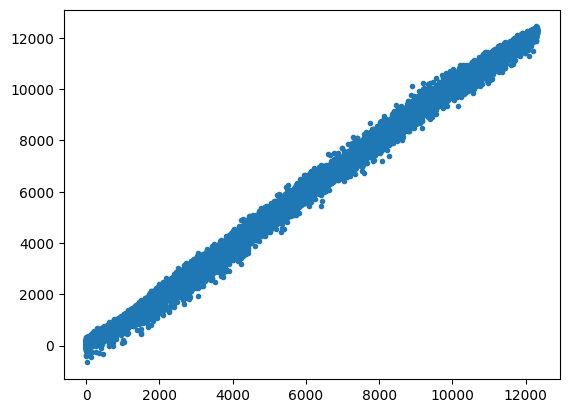

In [75]:
plt.figure()

plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')

plt.show()

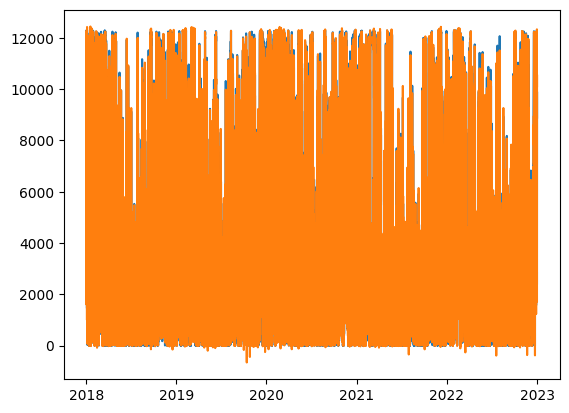

In [76]:
plt.figure()

plt.plot(target_result[target_feature])
plt.plot(target_result["target_prediction"])

plt.show()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_18476\3663099147.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target_prediction.resample("M").sum().plot()


<Axes: >

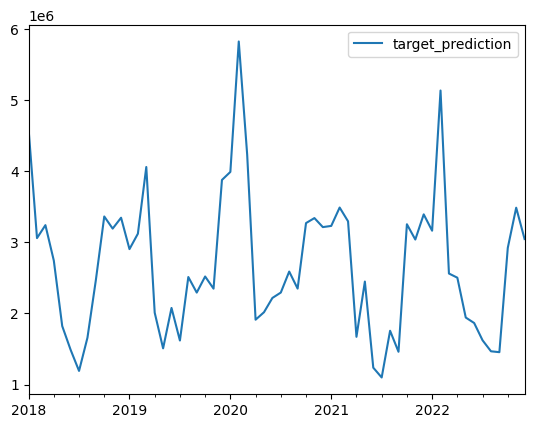

In [77]:
target_prediction.resample("M").sum().plot()

In [78]:
annual_prediction = target_prediction.resample("Y").sum()
annual_prediction

C:\Users\Charlie\AppData\Local\Temp\ipykernel_18476\3984842984.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_prediction = target_prediction.resample("Y").sum()


,target_prediction
2018-12-31,32139168.0
2019-12-31,30825950.0
2020-12-31,37219920.0
2021-12-31,29351044.0
2022-12-31,31144226.0


In [79]:
prediction_monthly = target_prediction.resample("M").sum()
prediction_monthly["month"] = prediction_monthly.index.month
print(prediction_monthly.groupby("month").mean().sum())
prediction_monthly.groupby("month").mean()

target_prediction    32136064.0
dtype: float32


C:\Users\Charlie\AppData\Local\Temp\ipykernel_18476\3700431752.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prediction_monthly = target_prediction.resample("M").sum()


,target_prediction
month,
1,3572976.750
2,4122144.750
3,3475192.000
4,2166040.000
5,1946254.250
6,1775769.375
7,1564011.625
8,1995090.250
9,2003766.375


In [80]:
prediction_8760 = target_prediction.copy()
prediction_8760["hour"] = (prediction_8760.index.day_of_year-1) * 24 + prediction_8760.index.hour

In [81]:
prediction_8760 = prediction_8760.groupby("hour").mean()

In [82]:
prediction_8760.index = pd.to_datetime(prediction_8760.index, unit='h', origin=pd.Timestamp('2021-01-01'))

In [83]:
prediction_8760

,target_prediction
hour,
2021-01-01 00:00:00,4034.298096
2021-01-01 01:00:00,4157.163086
2021-01-01 02:00:00,4869.206055
2021-01-01 03:00:00,5381.697754
2021-01-01 04:00:00,5400.723145
...,...
2022-01-01 19:00:00,1148.386597
2022-01-01 20:00:00,2654.693115
2022-01-01 21:00:00,1396.431152


In [84]:
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

In [85]:
prediction_12x24 = target_prediction.copy()
prediction_12x24["month"] = prediction_12x24.index.month
prediction_12x24["hour"] = prediction_12x24.index.hour
print((prediction_12x24.groupby(["month","hour"]).mean().unstack().sum(axis=1)*days_in_month).sum())
prediction_12x24.groupby(["month","hour"]).mean().unstack(["month"])

32106826.19140625


target_prediction                                                      \
month                1            2            3            4            5    
hour                                                                          
0           4716.338867  5857.723633  4467.964355  2884.571533  2460.285400   
1           4725.730469  5919.505859  4459.386230  2750.477783  2287.444092   
2           4840.771484  5873.608398  4495.347656  2631.877686  2291.952393   
3           4931.128418  6021.410645  4529.861816  2688.854004  2334.524170   
4           4811.501953  5923.337891  4601.050781  2666.009033  2463.933838   
5           4841.817871  5865.519043  4647.645996  2594.643066  2319.871826   
6           4956.580078  5852.447266  4535.817871  2575.165039  2191.594727   
7           5122.418945  5805.178711  4442.123047  2574.736084  2326.192627   
8           5018.923828  5819.987305  4391.945801  2759.085693  2477.291260   
9           4981.660645  5984.103516  4582.243164  2908.576904  2612.232666   
10          4813.365723  6376.204102  4856.908691  3224.074463  2764.405273   
11          4911.742188  6661.952148  4965.183105  3364.662598  2913.968750   
12          5063.195801  6757.228516  5044.406250  3393.450195  3052.288818   
13          4922.722656  6800.759766  5051.448730  3403.563721  3127.690186   
14          4656.134766  6618.372559  5137.039551  3449.982666  3069.134277   
15          4455.107422  6249.954102  5036.999023  3452.174072  3176.661133   
16          4385.615234  5907.616211  4824.174805  3497.129883  3141.088623   
17          4505.638184  5906.478516  4776.495117  3324.018066  2969.434082   
18          4721.788574  5971.954590  4583.484863  3178.463379  2637.928955   
19          4765.385254  6006.863281  4719.644531  3055.366211  2433.943115   
20          4935.572266  6024.674805  4620.348145  3082.026123  2377.333496   
21          4781.467773  6023.306641  4340.833008  3071.536621  2391.662842   
22          4668.554199  5982.856445  4498.430176  2872.934570  2462.542725   
23          4724.154297  5964.300781  4494.181152  2797.955322  2498.988525   

                                                                        \
month           6            7            8            9            10   
hour                                                                     
0      2319.115967  2056.683594  2355.404297  2601.820312  3952.063232   
1      2246.788574  1973.103638  2455.742188  2507.114258  3903.042236   
2      2239.469482  1904.941284  2362.838379  2540.550049  3914.464111   
3      2314.155273  1973.147583  2327.116455  2543.458008  3930.687012   
4      2227.359863  2068.193115  2398.637695  2647.774170  3918.906738   
5      2042.822510  1904.196777  2300.508789  2625.469727  3949.738281   
6      2067.451172  1695.104004  2050.051514  2558.383545  4051.590332   
7      2321.702393  1757.979004  2132.473145  2369.833984  3942.672119   
8      2470.252197  1853.254883  2393.299561  2396.283203  3915.453125   
9      2542.753662  2008.476807  2565.894043  2699.537598  4005.802490   
10     2518.504883  2131.087158  2870.049072  2927.838379  4446.310547   
11     2722.035645  2195.870850  3007.452881  3220.058594  4723.819336   
12     2867.941406  2287.003906  3317.339600  3417.938721  4940.809570   
13     2905.985840  2451.359863  3487.862549  3493.743896  4857.328613   
14     2878.638672  2482.979736  3414.228516  3456.354004  4545.987793   
15     2806.158203  2450.769043  3348.506836  3275.078125  4177.782227   
16     2749.333008  2427.409180  3361.074219  3157.089600  3734.773438   
17     2764.662109  2304.390625  3091.163574  2715.053467  3690.665771   
18     2581.400146  2134.685547  2608.335938  2587.989014  4050.600342   
19     2344.949463  2044.603882  2358.265625  2628.752930  4231.825684   
20     2239.675049  2004.936523  2435.880371  2606.633545  4066.789062   
21     2323.294434  2018.782715  2589.818359  2580.268311  4010.134766   
22     2346.375000  21